In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
%matplotlib inline

In [2]:
ca_housing_dataset_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
df = pd.read_csv(ca_housing_dataset_url)
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Preparing the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2 we are going to use all columns of the dataset. Do the following to prepare the data:

* Keep only the records where ocean_proximity is either `'<1H OCEAN'` or `'INLAND'`.
* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train / validation / test split with 60% / 20% / 20% distribution.
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [5]:
df = df.loc[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.median_house_value = np.log1p(df.median_house_value)

In [6]:
X = df.drop('median_house_value', axis=1)
y = df.median_house_value

In [7]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [8]:
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_cat_train = dv.fit_transform(train_dict)
# you first need to fit the arrays before you have access to the feature names
feature_names = list(dv.get_feature_names_out())
X_cat_val = dv.transform(val_dict)
X_cat_test = dv.transform(test_dict)

### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. Train a model with `max_depth=1`. Which feature is used for splitting the data?

* ocean_proximity
* total_rooms
* latitude
* population

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    dt = DecisionTreeRegressor(max_depth=1)
    dt.fit(X_cat_train, y_train)

[Text(0.5, 0.75, 'ocean_proximity=<1H OCEAN <= 0.5\nsquared_error = 0.322\nsamples = 9411\nvalue = 12.011'),
 Text(0.25, 0.25, 'squared_error = 0.23\nsamples = 3924\nvalue = 11.607'),
 Text(0.75, 0.25, 'squared_error = 0.186\nsamples = 5487\nvalue = 12.301')]

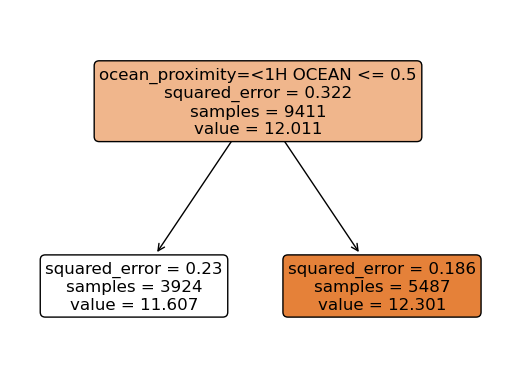

In [10]:
plot_tree(dt, filled=True, rounded=True, feature_names=feature_names, fontsize=12)

### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    rf = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)
    rf.fit(X_cat_train, y_train)
    y_pred = rf.predict(X_cat_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [12]:
rmse.round(3)

0.245

### Question 3

Now let's experiment with the `n_estimators` parameter.

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to 1.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving?

* 10
* 25
* 50
* 160

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    scores_ne = []
    for n_est in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n_est, n_jobs=-1, random_state=1)
        rf.fit(X_cat_train, y_train)
        y_pred = rf.predict(X_cat_val)
        scores_ne.append((n_est, np.sqrt(mean_squared_error(y_val, y_pred))))

In [14]:
scores_ne_df = pd.DataFrame(scores_ne, columns=['n_estimators', 'rmse'])
scores_ne_df = scores_ne_df.sort_values(by='rmse', ascending=True).reset_index(drop=True)
scores_ne_df.head()

,n_estimators,rmse
0,170,0.233299
1,160,0.233338
2,180,0.233470
3,150,0.233496
4,140,0.233606


### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: [10, 15, 20, 25]
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    scores_md_ne = []
    for max_d in range(10, 26, 5):
        for n_est in range(10, 201, 10):
            rf = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, n_jobs=-1, random_state=1)
            rf.fit(X_cat_train, y_train)
            y_pred = rf.predict(X_cat_val)
            scores_md_ne.append((max_d, n_est, np.sqrt(mean_squared_error(y_val, y_pred))))

In [16]:
scores_md_ne_df = pd.DataFrame(scores_md_ne, columns=['max_depth', 'n_estimators', 'rmse'])
scores_md_ne_df = scores_md_ne_df.sort_values(by='rmse', ascending=True).reset_index(drop=True)
scores_md_ne_df.head()

,max_depth,n_estimators,rmse
0,25,160,0.233425
1,25,170,0.233438
2,25,150,0.233559
3,25,180,0.233631
4,25,140,0.233636


### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
 * `n_estimators=10`,
 * `max_depth=20`,
 * `random_state=1`,
 * `n_jobs=-1` (optional)

Get the feature importance information from this model. What's the most important feature (among these 4)?

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)
    rf.fit(X_cat_train, y_train)
    feature_importances = zip(feature_names, rf.feature_importances_)
features_df = pd.DataFrame(feature_importances, columns=['feature_name', 'feature_importance_value'])
features_df = features_df.sort_values(by='feature_importance_value', ascending=False).reset_index(drop=True)
features_df.head()

,feature_name,feature_importance_value
0,median_income,0.335592
1,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101956
3,longitude,0.086276
4,ocean_proximity=INLAND,0.073806
